# Simulations for PMA abstract

## 0. Imports

In [1]:
import numpy as np
import time as t
import random
from oawidgets.plantgl import *
from openalea.plantgl.all import Material, Color3, Scene
import oawidgets.mtg

from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.display import build_scene, display_scene
from openalea.archicrop.simulation import read_sti_file, read_xml_file, LHS_param_sampling, params_for_curve_fit
import matplotlib.pyplot as plt
%gui qt

In [2]:
random.seed(18)

## 1. Set management parameters

Set parameters regarding the spatial (and temporal) configuration of the crop.

In [3]:
file_tec_xml = 'Mais_tec.xml'
params_tec = ['densitesem', 'interrang']
tec_stics = read_xml_file(file_tec_xml, params_tec)
sowing_density = tec_stics['densitesem']
inter_row = 0.4

## 2. Format crop-scale growth and senescence dynamics

From crop-scale data either measured or simulated with a crop model, generate a dictionnary of dictionnaries for each day with the following values :
 - "Thermal time" (float): cumulated thermal time from beginning of simulation to current day (in °C.day)
 - "Phenology" (str): current phenological stage (germination, juvenile, exponential or repro)
 - "Plant leaf area" (float): plant leaf area (in cm²) 
 - "Leaf area increment" (float): leaf area increment compared to previous day (in cm²) 
 - "Plant senescent leaf area" (float): senescent plant leaf area (in cm²) 
 - "Senescent leaf area increment" (float): senescent leaf area increment compared to previous day (in cm²) 
 - "Plant height" (float): plant height (in cm) 
 - "Height increment" (float): height increment compared to previous day (in cm).

In [4]:
stics_output_file = 'mod_smaize.sti'
daily_dynamics = read_sti_file(stics_output_file, sowing_density)

# Time series 
# for thermal time, plant leaf area, plant senescent leaf area and plant height
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]

In [5]:
file_plt_xml = 'corn_plt.xml'
params_sen = ['durvieF', 'ratiodurvieI']
sen_stics = read_xml_file(file_plt_xml, params_sen)
lifespan = sen_stics['durvieF'] # leaf lifespan from appearance in exponential phase
lifespan_early = sen_stics['ratiodurvieI'] * lifespan # leaf lifespan from appearance in juvenile phase

## 3. Set plant architectural parameters

Set topological, geometrical and developmental parameters, in a range corresponding a given species, found in literature.

In [61]:
archi = dict(
    nb_phy=[10,30], # number of phytomers on the main stem
    nb_short_phy=4,
    
    # Stem
    height=3*max(height_canopy), # potential plant height
    stem_q=1.0, # parameter for ligule height geometric distribution along axis
    diam_base=2.5, # stem base diameter
    diam_top=1.5, # stem top diameter

    # Leaf area distribution along the stem  
    leaf_area=1.2*max(leaf_area_plant), # potential plant leaf area
    rmax=[0.4,0.8], #relative position of largest leaf on the stem
    skew=0.005, # skewness for leaf area distribution along axis

    # blade area
    wl=0.12, # leaf blade width-to-length ratio 
    klig=0.6, # parameter for leaf blade shape
    swmax=0.55, # relative position of maximal blade width
    f1=0.64, # parameter for leaf blade shape
    f2=0.92, # parameter for leaf blade shape

    # blade curvature
    insertion_angle=35, # leaf blade insertion angle
    scurv=0.7, #  relative position of inflexion point
    curvature=120, # leaf blade insertion-to-tip angle
    phyllotactic_angle=180, # phyllotactic angle
    phyllotactic_deviation=10, # half-deviation to phyllotactic angle

    # Development
    phyllochron=30, # phyllochron, i.e. stem element appearance rate
    plastochron=38, # plastochron, i.e. leaf blade appearance rate

    # Senescence 
    leaf_lifespan = [lifespan_early, lifespan], # leaf lifespan from appearance

    # Tillering
    nb_tillers=0, # number of tillers
    tiller_delay=1, # delay, as factor of phyllochron, between the appearance of a phytomer and the appearance of its tiller
    tiller_angle=30,
    reduction_factor=1 # reduction factor between tillers of consecutive order
)

In [62]:
# Function to process parameters and generate samples
# Generate parameter sets
param_sets = LHS_param_sampling(archi, daily_dynamics, n_samples=200)
print(len(param_sets))

145


In [63]:
# Select parameters sets for which the model fits the LAI and the height curves of the crop model, with a given error.

# Start the timer
start_time = t.time()

fitting_sim = params_for_curve_fit(param_sets, curves=daily_dynamics, error_LA=0.05, error_height=0.05)

# End the timer
end_time = t.time()

# Calculate elapsed time
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes")

Elapsed time: 4.0118 minutes


In [64]:
print(len(fitting_sim['mtg']))

14


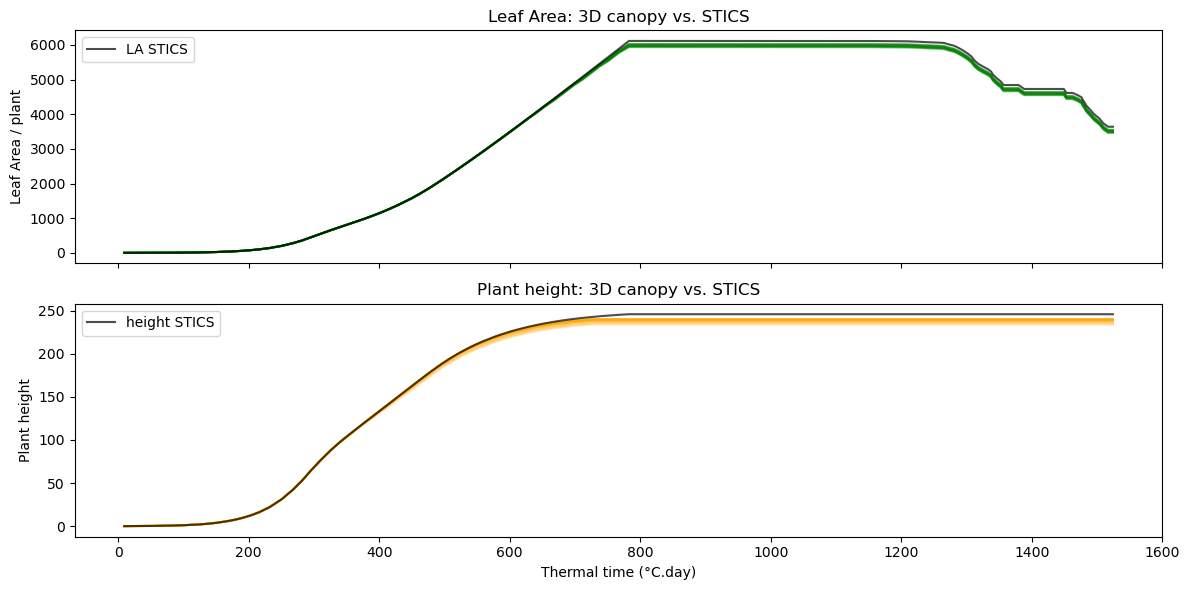

In [65]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  # 1 row, 2 columns

# Plot on the first subplot
for result in fitting_sim['LA']:
    axes[0].plot(thermal_time, result,  color="green", alpha=0.3)
    # print(result)
axes[0].plot(thermal_time, [la-sen for la, sen in zip(leaf_area_plant, sen_leaf_area_plant)], color="black", label="LA STICS", alpha=0.7)
# axes[0].set_xlabel("Thermal time (°C.day)")
axes[0].set_ylabel("Leaf Area / plant")
axes[0].set_title("Leaf Area: 3D canopy vs. STICS")
axes[0].legend(loc=2)

# Plot on the second subplot
for result in fitting_sim['height']:
    axes[1].plot(thermal_time, result, color="orange", alpha=0.3)
axes[1].plot(thermal_time, height_canopy, color="black", label="height STICS", alpha=0.7)
axes[1].set_xlabel("Thermal time (°C.day)")
axes[1].set_ylabel("Plant height")
axes[1].set_title("Plant height: 3D canopy vs. STICS")
axes[1].legend(loc=2)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [66]:
# fitting_sim['mtg'][-1][85].properties()

In [82]:
scene, _ = build_scene(fitting_sim['mtg'][11][60])
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## 7. Morphospace

In [74]:
morpho = {
    i : [p['nb_phy'],p['rmax']]
    for i,p in enumerate(fitting_sim['params'])
}

print(morpho)
# print([p['nb_phy'] for p in fitting_sim['params']])
# print([round(p['wl'],2) for p in fitting_sim['params']])

{0: [10, 0.7523652476854087], 1: [11, 0.790367512862615], 2: [16, 0.7933552884792667], 3: [13, 0.7584636168106395], 4: [17, 0.7829631433992157], 5: [10, 0.6497503774053339], 6: [14, 0.7292801345497191], 7: [15, 0.7815790225111005], 8: [11, 0.7468096381468596], 9: [12, 0.7244449264149907], 10: [10, 0.7306863421701044], 11: [18, 0.7695172336288454], 12: [10, 0.7889013015660806], 13: [12, 0.7877876722990788]}


In [75]:
# Get key with min of the first element
min_first = min(morpho.items(), key=lambda x: x[1][0])[0]

# Get key with max of the first element
max_first = max(morpho.items(), key=lambda x: x[1][0])[0]

# Get key with min of the second element
min_second = min(morpho.items(), key=lambda x: x[1][1])[0] 

# Get key with max of the second element
max_second = max(morpho.items(), key=lambda x: x[1][1])[0]

# Collect unique IDs
result_ids = [min_first, max_first, min_second, max_second]

print(result_ids)

[0, 11, 5, 2]


In [76]:
morpho_list = [fitting_sim['mtg'][id] for id in result_ids]
for g in morpho_list:
    print(g[120])

MTG : nb_vertices=23, nb_scales=4
MTG : nb_vertices=39, nb_scales=4
MTG : nb_vertices=23, nb_scales=4
MTG : nb_vertices=35, nb_scales=4


In [83]:
# times = [i for i,t in enumerate(thermal_time) if i%12==0]
times = [20, 35, 50, 90, 140]
# mean_time = sum(times) / len(times)
# positions = [(x, 6*(t-mean_time), z) for x in [0,300] for z in [0,300] for t in times]
positions = [(x, 200*i, z) for x in [0,300] for z in [0,300] for i,t in enumerate(times)]
# print(positions)
nice_green = Color3((50, 100, 0))
mtgs = [g for gs in morpho_list for i,g in enumerate(gs) if i in times]
scene, _ = build_scene(mtgs, position=positions, senescence=True, leaf_material = Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…